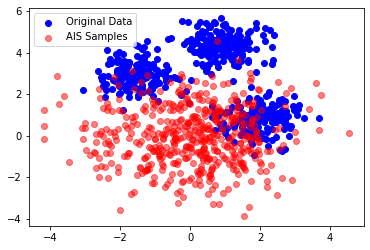

In [4]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# 1. GMM 데이터셋 생성
n_samples = 500
n_components = 3
X, y = make_blobs(n_samples=n_samples, centers=n_components, cluster_std=0.60, random_state=0)

# 2. GMM 모델 학습
gmm = GaussianMixture(n_components=n_components, random_state=0)
gmm.fit(X)

# 3. Annealed Importance Sampling (AIS) 함수 정의
def ais_sampling(gmm, n_samples, n_intermediate_distributions):
    # 초기 분포: 표준 정규 분포
    initial_samples = np.random.randn(n_samples, X.shape[1])
    
    # 중간 분포 설정
    betas = np.linspace(0, 1, n_intermediate_distributions)
    
    samples = initial_samples
    weights = np.ones(n_samples)
    
    for i in range(1, len(betas)):
        beta_prev = betas[i-1]
        beta_curr = betas[i]
        
        # 중간 분포의 비율 계산
        log_weights_prev = gmm.score_samples(samples) * beta_prev
        log_weights_curr = gmm.score_samples(samples) * beta_curr
        
        # 가중치 업데이트
        weights *= np.exp(log_weights_curr - log_weights_prev)
        
        # 새로운 샘플 생성
        samples = samples + np.random.randn(n_samples, X.shape[1]) * np.sqrt(beta_curr - beta_prev)
    
    return samples, weights

# 4. AIS를 사용하여 샘플링 수행
n_intermediate_distributions = 100
samples, weights = ais_sampling(gmm, n_samples, n_intermediate_distributions)

# 5. 결과 시각화
plt.scatter(X[:, 0], X[:, 1], c='blue', label='Original Data')
plt.scatter(samples[:, 0], samples[:, 1], c='red', alpha=0.5, label='AIS Samples')
plt.legend()
plt.show()

In [2]:
import numpy as np
import torch
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. GMM 데이터셋 생성
n_samples = 100000
n_components = 25
X, y = make_blobs(n_samples=n_samples, centers=n_components, cluster_std=0.60, random_state=0)
X = torch.tensor(X, dtype=torch.float32).to(device)

# 2. GMM 모델 학습 (PyTorch로 구현)
class GMM:
    def __init__(self, n_components):
        self.n_components = n_components
        self.means = None
        self.covariances = None
        self.weights = None

    def fit(self, X):
        from sklearn.mixture import GaussianMixture
        gmm = GaussianMixture(n_components=self.n_components, random_state=0)
        gmm.fit(X.cpu().numpy())
        self.means = torch.tensor(gmm.means_, dtype=torch.float32).to(device)
        self.covariances = torch.tensor(gmm.covariances_, dtype=torch.float32).to(device)
        self.weights = torch.tensor(gmm.weights_, dtype=torch.float32).to(device)

    def score_samples(self, X):
        log_prob = []
        for i in range(self.n_components):
            mean = self.means[i]
            cov = self.covariances[i]
            dist = torch.distributions.MultivariateNormal(mean, cov)
            log_prob.append(dist.log_prob(X) + torch.log(self.weights[i]))
        log_prob = torch.stack(log_prob, dim=1)
        return torch.logsumexp(log_prob, dim=1)

gmm = GMM(n_components=n_components)
gmm.fit(X)

# 3. Annealed Importance Sampling (AIS) 함수 정의
def ais_sampling(gmm, n_samples, n_intermediate_distributions):
    # 초기 분포: 표준 정규 분포
    initial_samples = torch.randn(n_samples, X.shape[1]).to(device)
    
    # 중간 분포 설정
    betas = torch.linspace(0, 1, n_intermediate_distributions).to(device)
    
    samples = initial_samples
    weights = torch.ones(n_samples).to(device)
    
    for i in range(1, len(betas)):
        beta_prev = betas[i-1]
        beta_curr = betas[i]
        
        # 중간 분포의 비율 계산
        log_weights_prev = gmm.score_samples(samples) * beta_prev
        log_weights_curr = gmm.score_samples(samples) * beta_curr
        
        # 가중치 업데이트
        weights *= torch.exp(log_weights_curr - log_weights_prev)
        
        # 새로운 샘플 생성
        samples = samples + torch.randn(n_samples, X.shape[1]).to(device) * torch.sqrt(beta_curr - beta_prev)
    
    return samples, weights

# 4. AIS를 사용하여 샘플링 수행
n_intermediate_distributions = 100
samples, weights = ais_sampling(gmm, n_samples, n_intermediate_distributions)

# 5. 결과 시각화 (GPU에서 CPU로 이동)
samples = samples.cpu().detach().numpy()
X = X.cpu().detach().numpy()

plt.scatter(X[:, 0], X[:, 1], c='blue', label='Original Data')
plt.scatter(samples[:, 0], samples[:, 1], c='red', alpha=0.5, label='AIS Samples')
plt.legend()
plt.show()

ModuleNotFoundError: No module named 'sklearn'